In [1]:
import os
import csv
import numpy as np
import cv2
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg


samples = []
with open('./driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)
samples = samples[1:]
print(samples[150])

['IMG/center_2016_12_01_13_32_53_459.jpg', ' IMG/left_2016_12_01_13_32_53_459.jpg', ' IMG/right_2016_12_01_13_32_53_459.jpg', ' 0.2531306', ' 0.9855326', ' 0', ' 30.18125']


In [6]:
#Preporcessing steps
def trans_image_test(image,steer,trans_range):
    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    steer_ang = steer + tr_x/trans_range*2*.2
    tr_y = 10*np.random.uniform()-10/2
    #tr_y = 0
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    image_tr = cv2.warpAffine(image,Trans_M,(image.shape[1],image.shape[0]))

    return image_tr,steer_ang

def crop_resize_img_test(img, ang, size=(64, 64)):
    crop_img = np.copy(img[60:140,:])
    trans_img, trans_ang = trans_image_test(crop_img, ang, 150)
    return cv2.resize(trans_img, size), trans_ang
    
def crop_resize_img(img, size=(64, 64)):
    return cv2.resize(np.copy(img[60:140,:]), size)

def flip_imges(img_list, angles_list):
    flip_list = np.zeros(img_list.shape, dtype = np.float32)
    ang_list = np.zeros(angles_list.shape, dtype = np.float32)
    for i in range(img_list.shape[0]):
        flip_list[i] = cv2.flip(np.copy(img_list[i]), 1) #flip along y-axis
        if angles_list[i][0] == 0.0:
            ang_list[i] = angles_list[i][0]
        else:
            ang_list[i] = -1. * angles_list[i][0] #flip angle
    return flip_list, ang_list

def apply_brigntness(img_list):
    new_img_list = np.zeros(img_list.shape, dtype = np.float32)
    for i in range(img_list.shape[0]):
        #Convert 2 HSV colorspace from RGB colorspace
        hsv = cv2.cvtColor(np.copy(img_list[i]), cv2.COLOR_RGB2HSV)
        #Generate new random brightness
        rand = np.random.uniform(0.3,1.0)
        hsv[:,:,2] = rand*hsv[:,:,2]
        #Convert back to RGB colorspace
        new_img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
        new_img_list[i] = new_img
    return new_img_list
def trans_image(img_list,angles_list,trans_range):
    trans_list = np.zeros(img_list.shape, dtype = np.float32)
    ang_list = np.zeros(angles_list.shape, dtype = np.float32)
    for i in range(img_list.shape[0]):
        # Translation
        tr_x = trans_range*np.random.uniform()-trans_range/2
        ang_list[i] = angles_list[i] + tr_x/trans_range*2*.3
        tr_y = 10*np.random.uniform()-10/2
        Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
        trans_list[i] = cv2.warpAffine(np.copy(img_list[i]),Trans_M,(img_list.shape[1], img_list.shape[2]))

    return trans_list,ang_list 

In [31]:
def generator_test(samples, batch_size=32, is_validation = False):
    X_train = np.zeros((batch_size, 64, 64, 3), dtype=np.float32)# resized image
    y_train = np.zeros((batch_size, 1), dtype=np.float32)
    samples = sklearn.utils.shuffle(samples)
    while 1: # Loop forever so the generator never terminates
        #Generate "batch_size" of images here
        for i in range(0, len(samples), batch_size):
            j = 0
            start = i
            end = i+batch_size
            if end < len(samples):
                for idx in range(start, end):
                    choice = np.random.choice(3)
                    if is_validation == True:
                        choice = 0#for validation use only center image
                    str_ang = float(samples[idx][3])#get steering angle
                    img = mpimg.imread(samples[idx][choice].strip())#randomly read one of the center,left,right camera image
                    if choice == 1:
                        str_ang += 0.25
                    elif choice == 2:
                        str_ang -= 0.25
                    
                    if is_validation == False: #flip only for training data                      
                        #randomly flip the image
                        flip_prob = np.random.random()
                        if flip_prob > 0.5:
                            str_ang = -1 * str_ang
                            img = cv2.flip(img, 1)
                        #img, str_ang = trans_image_test(img, str_ang, 150)#randomly shift image and its angle  
                    img = img[50:140,:]#crop unwanted region
                    
                    X_train[j] = cv2.resize(img, (64,64))#resize image
                    y_train[j] = str_ang
                    j += 1
                yield(X_train, y_train)

In [32]:
# compile and train the model using the generator function
batch_size = 64
_, validation_samples_test = train_test_split(samples, test_size=0.2)#use 20% of samples for validation
train_generator = generator_test(samples, batch_size=batch_size)
validation_generator = generator_test(validation_samples_test, batch_size=batch_size, is_validation = True)
ch, row, col = 3, 64, 64  # Trimmed image format

In [33]:
from keras.backend import tf as ktf
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Activation, Lambda, Cropping2D, Flatten, ELU
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import Adam

pool_size = (3,3)

model = Sequential()
model.add(Lambda(lambda x: x/255.-0.5, input_shape=(row, col, ch)))

#Nvidia archetecture
model.add(Convolution2D(24,5,5,border_mode='valid', name='conv1', init='he_normal', subsample=(2, 2)))
model.add(ELU())
model.add(Convolution2D(36,5,5,border_mode='valid', name='conv2', init='he_normal', subsample=(2, 2)))
model.add(ELU())
model.add(Convolution2D(48,5,5,border_mode='valid', name='conv3', init='he_normal', subsample=(2, 2)))
model.add(ELU())
model.add(Convolution2D(64,3,3,border_mode='valid', name='conv4', init='he_normal'))
model.add(ELU())
model.add(Convolution2D(64,3,3,border_mode='valid', name='conv5', init='he_normal'))
model.add(ELU())
model.add(Flatten())
model.add(Dense(100,name='Dense2', init='he_normal'))
model.add(Dropout(0.5))
model.add(Dense(50,name='Dense3', init='he_normal'))
model.add(Dropout(0.5))
model.add(Dense(10,name='Dense4', init='he_normal'))
model.add(Dropout(0.5))
model.add(Dense(1,name='Output', init='he_normal'))

model.summary()
adam = Adam(lr=0.001)
model.compile(loss='mse', optimizer=adam)
train_samples_per_epoch = int(len(samples)/ batch_size) * batch_size *4
history_object = model.fit_generator(generator=train_generator, samples_per_epoch=train_samples_per_epoch, 
                                     validation_data=validation_generator, nb_val_samples=2*len(validation_samples_test), 
                                     nb_epoch=4, max_q_size=512)
model.save('model.h5')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_11 (Lambda)               (None, 64, 64, 3)     0           lambda_input_11[0][0]            
____________________________________________________________________________________________________
conv1 (Convolution2D)            (None, 30, 30, 24)    1824        lambda_11[0][0]                  
____________________________________________________________________________________________________
elu_51 (ELU)                     (None, 30, 30, 24)    0           conv1[0][0]                      
____________________________________________________________________________________________________
conv2 (Convolution2D)            (None, 13, 13, 36)    21636       elu_51[0][0]                     
___________________________________________________________________________________________

dict_keys(['loss', 'val_loss'])


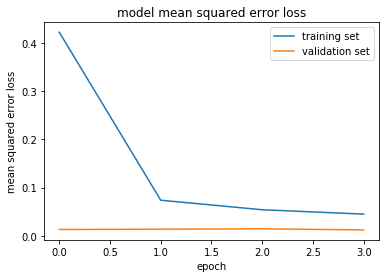

In [34]:
import matplotlib.pyplot as plt
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()